In [16]:
#Adjustments AI 
#Sample data creator


In [7]:
#Shared common config
SpecialFields=["AdjustmentType","AdjustmentName","AdjustedField"]
AuditFields=["OldVal","NewVal"]
SampleFields=["CustomerID","CustomerType","AccountType","Approach","RiskCategory","SubDivision","IsDefaulted","CountryCode"]
NumericFields=["Drawn","Undrawn"]
RatioFields=["PD"]
AdjustableFields=SampleFields+NumericFields+RatioFields #Used for thre adjustment mask
AdjustmentTypes=["Amend"]
AdjustmentNames=["Noise_6f","Noise_22d","Noise_116z","Noise_256n","Noise_128x","Noise_19b"]
AdjustedFields=SampleFields
CustomerID=["CUST238947","CUST563201","CUST981372","CUST450896","CUST712035","CUST103289","CUST665428","CUST359147","CUST804231","CUST192654"]
CustomerType=["Retail","Corporate","SME"]
RiskCategory=["Low","Medium","High"]
IsDefaulted=["0","1"]
CountryCode=["US","GB","DE"]
Approaches=["STD","FOU","ADV"]
SubDivisions=["HSBC_UK","HSBC_IR","HSBC_US","HSBC_AP","HSBC_CORP","HSBC_DEBTS"]
AccountTypes=["Current","Savings","Loan","Mortgage","Credit Card","Investment","Insurance","Other","Revolver"]
FieldMapping={"CustomerID":CustomerID,"CustomerType":CustomerType,"RiskCategory":RiskCategory,"IsDefaulted":IsDefaulted,"CountryCode":CountryCode,"Approach":Approaches,"SubDivision":SubDivisions,"AccountType":AccountTypes}
 


#Define adjustment rules
AdjustmentRules=[]
AdjustmentRules.append([[{"CustomerType":"Corporate"},{"RiskCategory":"High"}],["PD",0.75,"Market Downturn"]])
AdjustmentRules.append([[{"RiskCategory":"High"},{"IsDefaulted":"1"}],["CustomerType","Debt Recovery","Defaulting Cleanup"]])
AdjustmentRules.append([[{"CountryCode":"GB"},{"IsDefaulted":"0"}],["RiskCategory","Medium","BREXIT"]])
AdjustmentRules.append([[{"CountryCode":"GB"},{"IsDefaulted":"1"}],["RiskCategory","High","BREXIT_DEFAULTED"]])
AdjustmentRules.append([[{"CountryCode":"DE"},{"CustomerType":"Retail"}],["RiskCategory","Medium","German Retail Downturn"]])
AdjustmentRules.append([[{"CustomerType":"Corporate"},{"CountryCode":"US"}],["PD",0.75,"US Corporate Crunch"]])
AdjustmentRules.append([[{"CustomerType":"Corporate"},{"CountryCode":"US"}],["PD",0.75,"US Corporate Crunch"]])
AdjustmentRules.append([[{"Approach":"STD"},{"CountryCode":"US"}],["RiskCategory","High","US STD downgrade"]])
AdjustmentRules.append([[{"AccountType":"Credit Card"}],["RiskCategory","High","STD downgrade credit card"]])

In [16]:
#Generate random data with Adjustment rules applied
import pandas as pd
import numpy as np

#Sample Data Generator
records=20000

#Hide warmings from pandas
pd.options.mode.chained_assignment = None  # default='warn'

def GetRandomFieldValue(field):
    return np.random.choice(FieldMapping[field],1)[0]

#Checks if this row matches any adjustment rule, if so returns the [{fieldToUpdate:NewValue},AdjustmentComment]
def ValidateGetAdjustmentRule(row):
    for rule in AdjustmentRules:
        criteria=rule[0]
        adjustment=rule[1]

        #Check all criteria match
        allMatch=True
        for crit in criteria:
            #Split crit dictionary into key and value
            critField=list(crit.keys())[0]
            critValue=crit[critField]

            #Check if row matched
            if row[critField]!=critValue:
                allMatch=False
        
        if allMatch:
            return allMatch,adjustment
    
    return False,[]

#Accrue an adjustment mask for training
AdjustmentMask=[]

#Build numeric column mapping for Adjustable Fields
MaskMapping={}
for i in range(len(AdjustableFields)):
    MaskMapping[AdjustableFields[i]]=i+1
print(MaskMapping)

df=pd.DataFrame(columns=SampleFields+SpecialFields+AuditFields)
for mapping in FieldMapping:
    df[mapping]=np.random.choice(FieldMapping[mapping],records)
df["AdjustmentType"]=np.random.choice(AdjustmentTypes,records)
df["AdjustmentName"]=np.random.choice(AdjustmentNames,records)

#Adjusted field------------------------------------------------------------------------
df["AdjustedField"]=np.random.choice(AdjustedFields,records)
#df["AdjustedField"]="CustomerType"

for field in NumericFields:
    #Insert new column after first 1
    df[field]=np.random.randint(1000000, size=records)
for field in RatioFields:
    df[field]=np.random.randint(100, size=records)/100

#Add in audit fields
df["OldVal"]=np.nan
df["NewVal"]=np.nan

#Loop over each row and generate a new value for Oldval based on field
for index, row in df.iterrows():
    adjField=row["AdjustedField"]

    #Build empty adjustment mask
    RowMask=[""]+[0]*len(AdjustableFields)

    #Check if this row matches any adjustment rule
    matchesRule,rule = ValidateGetAdjustmentRule(row)

    #APPLY ADJUSTMENTS--------------------------------------
    if adjField not in NumericFields and adjField not in RatioFields:

        if matchesRule:
            
            #Split rule dictionary into key and value
            ruleTarget=rule[0]
            ruleValue=rule[1]
            ruleComment=rule[2]
            df["AdjustmentName"][index]=ruleComment
            df["AdjustedField"][index]=ruleTarget
            df["NewVal"][index]=ruleValue

            #Update current rowMask
            RowMask[MaskMapping[ruleTarget]]=1
            RowMask[0]=ruleComment

        else:
            #Random "noise" adjustments
            #df["OldVal"][index]=row[adjField]
            df["NewVal"][index]=GetRandomFieldValue(adjField)

        #Accrue row masks --------------------------------------
        AdjustmentMask.append(RowMask)

# #Reshuffle the numeric fields to the start
df=df.reindex(columns=SpecialFields+NumericFields+RatioFields+SampleFields+AuditFields)

#Remove OldVal Field
df=df.drop(columns=["OldVal"])

# #Write to CSV file
df.to_csv("SampleData.csv",index=False)
#df

#Make Adustment Mask dataframe
dfMask=pd.DataFrame(AdjustmentMask,columns=["AdjustmentName"]+AdjustableFields)
dfMask.to_csv("AdjustmentMask.csv",index=False)



{'CustomerID': 1, 'CustomerType': 2, 'AccountType': 3, 'Approach': 4, 'RiskCategory': 5, 'SubDivision': 6, 'IsDefaulted': 7, 'CountryCode': 8, 'Drawn': 9, 'Undrawn': 10, 'PD': 11}


,AdjustmentName,CustomerID,CustomerType,AccountType,Approach,RiskCategory,SubDivision,IsDefaulted,CountryCode,Drawn,Undrawn,PD
0,German Retail Downturn,0,0,0,0,1,0,0,0,0,0,0
1,US Corporate Crunch,0,0,0,0,0,0,0,0,0,0,1
2,Market Downturn,0,0,0,0,0,0,0,0,0,0,1
3,German Retail Downturn,0,0,0,0,1,0,0,0,0,0,0
4,,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,,0,0,0,0,0,0,0,0,0,0,0
19996,Market Downturn,0,0,0,0,0,0,0,0,0,0,1
19997,BREXIT,0,0,0,0,1,0,0,0,0,0,0
19998,Defaulting Cleanup,0,1,0,0,0,0,0,0,0,0,0


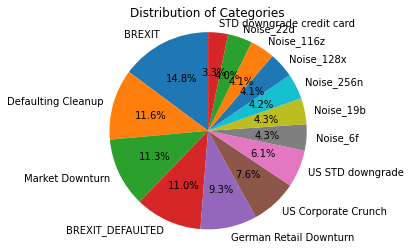

In [36]:
import matplotlib.pyplot as plt
# Replace 'Category' with the field you want to visualize
frequency = df['AdjustmentName'].value_counts()

# Plot the pie chart
plt.pie(frequency, labels=frequency.index, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Distribution of Categories')

# Equal aspect ratio ensures the pie chart is circular
plt.axis('equal')

#Make background white
plt.rcParams['axes.facecolor'] = 'white'

#Make background solid
plt.rcParams['axes.edgecolor'] = 'black'

# Display the chart
plt.show()


3

In [37]:
len(df["NewVal"].unique())

41